# **KGFarm**
**A Feature Discovery system for Machine learning workflows**
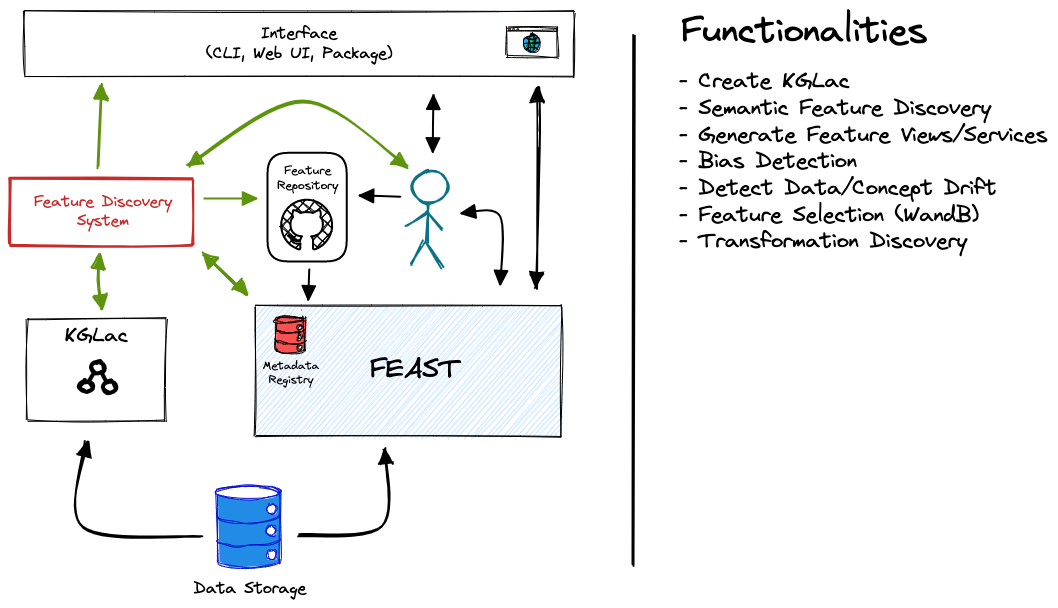






In [1]:
from operations.api import KGFarm
kgfarm = KGFarm()

Connected to Stardog!
Access the Stardog UI at: https://cloud.stardog.com/



**Automate generation of [Entities](https://docs.feast.dev/getting-started/concepts/entity) & [Feature Views](https://docs.feast.dev/getting-started/concepts/feature-view)**








In [2]:
kgfarm.get_entities()

,Entity_name,Entity_data_type,Physical_column,Physical_table,Uniqueness_ratio
0,country_name_life_expectancy,string,Country Name,life_expectancy.csv,1.00
1,customer_bank,string,customer_id,bank.csv,1.00
2,country_name_API_ILO_country_YU,string,Country Name,API_ILO_country_YU.csv,1.00
3,country_name_country_population,string,Country Name,country_population.csv,1.00
4,country_code_Country,string,Country.Code,Country.csv,1.00
5,country_name_fertility_rate,string,Country Name,fertility_rate.csv,1.00
6,customer_churn,integer,CustomerId,churn.csv,1.00
7,customer_Churn_Modelling,integer,CustomerId,Churn_Modelling.csv,1.00
8,customer_bank_stats,string,customer_id,bank_stats.csv,0.92


In [3]:
feature_view_df = kgfarm.get_feature_views()
feature_view_df

Showing all feature views


,Feature_view,Entity,Physical_column,Physical_table,File_source
0,Feature_view_01,None,None,Data.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Data.csv
1,Feature_view_02,None,None,Series.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Series.csv
2,Feature_view_03,country_code_Country,Country.Code,Country.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Country.csv
3,Feature_view_04,None,None,Series-Time.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Series-Time.csv
4,Feature_view_05,country_name_fertility_rate,Country Name,fertility_rate.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-bank-data-1960-to-2016/data/fertility_rate.csv
5,Feature_view_06,None,None,Country-Series.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Country-Series.csv
6,Feature_view_07,None,None,data.csv,/Users/shubhamvashisth/Documents/data/data_lake/health-nutrition-and-population-statistics/data/data.csv
7,Feature_view_08,customer_Churn_Modelling,CustomerId,Churn_Modelling.csv,/Users/shubhamvashisth/Documents/data/data_lake/bank-customer-churn-modeling/data/Churn_Modelling.csv
8,Feature_view_09,customer_churn,CustomerId,churn.csv,/Users/shubhamvashisth/Documents/data/data_lake/churn-for-bank-customers/data/churn.csv
9,Feature_view_10,None,None,FootNote.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/FootNote.csv


**Drop Feature Views**
  *   Pass the feature views to be deleted as a <code>pandas.Series</code> object.


In [4]:
kgfarm.drop_feature_view(drop=[feature_view_df.iloc[14]])

100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

Dropped  ['Feature_view_15'] successfully!


,Feature_view,Entity,Physical_column,Physical_table,File_source
0,Feature_view_01,None,None,Data.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Data.csv
1,Feature_view_02,None,None,Series.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Series.csv
2,Feature_view_03,country_code_Country,Country.Code,Country.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Country.csv
3,Feature_view_04,None,None,Series-Time.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Series-Time.csv
4,Feature_view_05,country_name_fertility_rate,Country Name,fertility_rate.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-bank-data-1960-to-2016/data/fertility_rate.csv
5,Feature_view_06,None,None,Country-Series.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Country-Series.csv
6,Feature_view_07,None,None,data.csv,/Users/shubhamvashisth/Documents/data/data_lake/health-nutrition-and-population-statistics/data/data.csv
7,Feature_view_08,customer_Churn_Modelling,CustomerId,Churn_Modelling.csv,/Users/shubhamvashisth/Documents/data/data_lake/bank-customer-churn-modeling/data/Churn_Modelling.csv
8,Feature_view_09,customer_churn,CustomerId,churn.csv,/Users/shubhamvashisth/Documents/data/data_lake/churn-for-bank-customers/data/churn.csv
9,Feature_view_10,None,None,FootNote.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/FootNote.csv


**Update Entity for a particular Feature_view**
  *   Use KGFarm's <code>get_optional_physcial_representations()</code> to discover other promising physical representations of an entity.
  *   To update existing entities of your choice. Use KGFarm's <code>update_entity()</code> API. 
  *   Pass your choice(s) from <code>get_optional_physcial_representations()</code> to <code>update_entity(entity_to_update_info: list)</code>.

In [5]:
optional_physical_representations_df = kgfarm.get_optional_physical_representations()
optional_physical_representations_df

,Feature_view,Entity,Current_physical_representation,Optional_physical_representation,Data_type,Uniqueness_ratio,Physical_table
0,Feature_view_03,country_code_Country,Country.Code,Long.Name,string,1.0,Country.csv
1,Feature_view_03,country_code_Country,Country.Code,Short.Name,string,1.0,Country.csv
2,Feature_view_03,country_code_Country,Country.Code,Table.Name,string,1.0,Country.csv
3,Feature_view_05,country_name_fertility_rate,Country Name,Country Code,string,1.0,fertility_rate.csv
4,Feature_view_08,customer_Churn_Modelling,CustomerId,EstimatedSalary,float,1.0,Churn_Modelling.csv
5,Feature_view_08,customer_Churn_Modelling,CustomerId,RowNumber,integer,1.0,Churn_Modelling.csv
6,Feature_view_09,customer_churn,CustomerId,EstimatedSalary,float,1.0,churn.csv
7,Feature_view_09,customer_churn,CustomerId,RowNumber,integer,1.0,churn.csv
8,Feature_view_12,country_name_life_expectancy,Country Name,Country Code,string,1.0,life_expectancy.csv
9,Feature_view_14,country_name_country_population,Country Name,Country Code,string,1.0,country_population.csv


In [6]:
kgfarm.update_entity([optional_physical_representations_df.iloc[0]])

100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


Entity 'country_code_Country' uses 'Long.Name' as its physical representation


,Feature_view,Entity,Physical_column,Physical_table,File_source
0,Feature_view_01,None,None,Data.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Data.csv
1,Feature_view_02,None,None,Series.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Series.csv
2,Feature_view_03,country_code_Country,Long.Name,Country.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Country.csv
3,Feature_view_04,None,None,Series-Time.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Series-Time.csv
4,Feature_view_05,country_name_fertility_rate,Country Name,fertility_rate.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-bank-data-1960-to-2016/data/fertility_rate.csv
5,Feature_view_06,None,None,Country-Series.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/Country-Series.csv
6,Feature_view_07,None,None,data.csv,/Users/shubhamvashisth/Documents/data/data_lake/health-nutrition-and-population-statistics/data/data.csv
7,Feature_view_08,customer_Churn_Modelling,CustomerId,Churn_Modelling.csv,/Users/shubhamvashisth/Documents/data/data_lake/bank-customer-churn-modeling/data/Churn_Modelling.csv
8,Feature_view_09,customer_churn,CustomerId,churn.csv,/Users/shubhamvashisth/Documents/data/data_lake/churn-for-bank-customers/data/churn.csv
9,Feature_view_10,None,None,FootNote.csv,/Users/shubhamvashisth/Documents/data/data_lake/world-gender-statistics/data/FootNote.csv


## **A practical usecase**

**Entity search**

In [7]:
import pandas as pd
entity_info = kgfarm.search_entity('customer')
entity_info

,Entity,Physical_representation,Feature_view,Physical_table,Number_of_rows,File_source
0,customer_bank_stats,customer_id,Feature_view_13,bank_stats.csv,12162,/Users/shubhamvashisth/Documents/data/data_lake/bank-marketing-dataset/data/bank_stats.csv
1,customer_bank,customer_id,Feature_view_11,bank.csv,11162,/Users/shubhamvashisth/Documents/data/data_lake/bank-marketing-dataset/data/bank.csv
2,customer_Churn_Modelling,CustomerId,Feature_view_08,Churn_Modelling.csv,10000,/Users/shubhamvashisth/Documents/data/data_lake/bank-customer-churn-modeling/data/Churn_Modelling.csv
3,customer_churn,CustomerId,Feature_view_09,churn.csv,10000,/Users/shubhamvashisth/Documents/data/data_lake/churn-for-bank-customers/data/churn.csv


   
**Conventional approach for building a machine learning classifier** 


In [8]:
entity_df = pd.read_csv(entity_info.iloc[0].File_source)
print(entity_info.iloc[0].Physical_table)
entity_df

bank_stats.csv


,event_timestamp,customer_id,age,balance,day,duration,campaign,pdays,previous,n_accounts,deposit,membership
0,2022-08-10 00:00:34.333878,C_11573,49,1093,12,243,2,91,2,2,1,yes
1,2022-08-10 00:02:11.333878,C_16087,59,1304,18,220,1,-1,0,2,1,no
2,2022-08-10 00:04:35.333878,C_10403,25,129,12,176,3,-1,0,2,1,yes
3,2022-08-10 00:05:05.333878,C_17775,58,2920,9,136,1,-1,0,2,1,no
4,2022-08-10 00:05:21.333878,C_08239,26,11862,13,119,1,-1,0,2,1,yes
...,...,...,...,...,...,...,...,...,...,...,...,...
12157,2022-08-19 23:55:47.333878,C_11747,32,2688,14,216,1,57,1,2,1,yes
12158,2022-08-19 23:58:53.333878,C_08190,54,0,5,744,3,-1,0,2,1,yes
12159,2022-08-19 23:59:03.333878,C_09100,26,620,22,223,1,94,1,2,1,yes
12160,2022-08-19 23:59:47.333878,C_13025,49,1202,18,122,1,-1,0,2,1,no


In [9]:
entity_df['membership'] = entity_df['membership'].apply(lambda x: 1 if x == 'yes' else 0)
entity_df.reset_index(drop=True, inplace=True)
entity_df

,event_timestamp,customer_id,age,balance,day,duration,campaign,pdays,previous,n_accounts,deposit,membership
0,2022-08-10 00:00:34.333878,C_11573,49,1093,12,243,2,91,2,2,1,1
1,2022-08-10 00:02:11.333878,C_16087,59,1304,18,220,1,-1,0,2,1,0
2,2022-08-10 00:04:35.333878,C_10403,25,129,12,176,3,-1,0,2,1,1
3,2022-08-10 00:05:05.333878,C_17775,58,2920,9,136,1,-1,0,2,1,0
4,2022-08-10 00:05:21.333878,C_08239,26,11862,13,119,1,-1,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12157,2022-08-19 23:55:47.333878,C_11747,32,2688,14,216,1,57,1,2,1,1
12158,2022-08-19 23:58:53.333878,C_08190,54,0,5,744,3,-1,0,2,1,1
12159,2022-08-19 23:59:03.333878,C_09100,26,620,22,223,1,94,1,2,1,1
12160,2022-08-19 23:59:47.333878,C_13025,49,1202,18,122,1,-1,0,2,1,0


**Manual feature selection**

In [10]:
X = entity_df[['age', # here age, balance, day, duration, ... are the necessary features for model building
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'n_accounts',
 'deposit']]

y = entity_df['membership']

**Training Machine learning classifiers**<br><br>
<i>(Random forest, Gradient boosting and naive bayes in this case)</i>

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# instanciate the models
random_forest_classifier = RandomForestClassifier()
gradient_boosting_classifier = GradientBoostingClassifier()
naive_bayes_classifier = GaussianNB()

# fit the models on data
random_forest_classifier.fit(X_train, y_train)
gradient_boosting_classifier.fit(X_train, y_train)
naive_bayes_classifier.fit(X_train, y_train)

# evaluate model performance
y_pred = random_forest_classifier.predict(X_test)
f1_random_forest_classifier = round(f1_score(y_test, y_pred), 3)
y_pred = gradient_boosting_classifier.predict(X_test)
f1_gradient_boosting_classifier = round(f1_score(y_test, y_pred), 3)
y_pred = naive_bayes_classifier.predict(X_test)
f1_naive_bayes_classifier = round(f1_score(y_test, y_pred), 3)

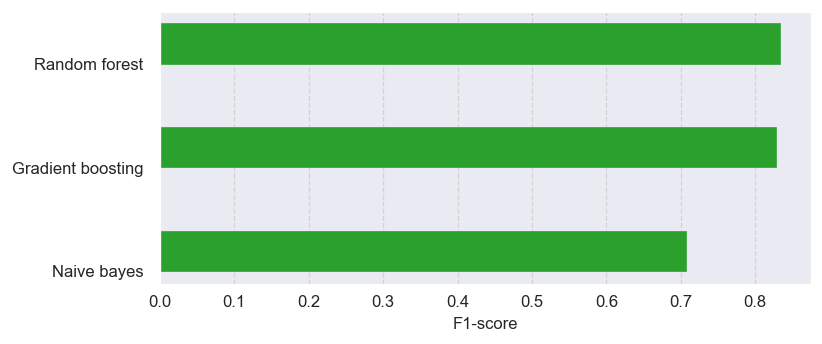

Random forest classifier (f1-score):      0.833
Gradient boosting classifier (f1-score):  0.828
Naive bayes classifier (f1-score):        0.707


In [12]:
from helpers.helper import plot_scores, plot_comparison
conventional_approach = {'Random forest classifier': f1_random_forest_classifier,
                         'Gradient boosting classifier': f1_gradient_boosting_classifier,
                         'Naive bayes classifier': f1_naive_bayes_classifier}
    
plot_scores(conventional_approach)

for classifier, f1 in conventional_approach.items():
    print(f"{'{} (f1-score):'.format(classifier):<42}{f1:>1}")

##  **Automating Feature discovery and transformations using KGFarm** 

**Searching for enrichable tables**<br><br> 
<code>kgfarm.search_enrichment_options()</code> returns set of tables / <code>entity_df</code> and the corresponding Feature view that could be used in order to enrich them with fresh set of features.
  *   <b><code>Joinability_strength</code></b> represents how much a given table / <code>entity_df</code> and a Feature view are joinable. 
  * <b>    You can also pass your <code>entity_df</code> to <code>kgfarm.search_enrichment_options(entity_df: pd.Dataframe)</code> to get the corresponding Feature view that could be used for feature enrichment.</b>

In [13]:
enrichment_info = kgfarm.search_enrichment_options(entity_df)
enrichment_info

100%|██████████| 13/13 [00:00<00:00, 41.21it/s]


,Enrich_with,Physical_joinable_table,Join_key,Joinability_strength,File_source,Dataset_feature_view
0,Feature_view_11,bank.csv,customer_id,100%,/Users/shubhamvashisth/Documents/data/data_lake/bank-marketing-dataset/data/bank.csv,bank-marketing-dataset


**Enriching data with point in time correct joins**<hr>

KGFarm can join features from a feature view to an entity dataframe in a <b>point-in-time correct way</b> i.e. KGFarm can retrieve values at a specific points in time.
KGFarm scans backward in time from the entity dataframe timestamp up to a maximum of the <code>TTL</code>  (parameter passed by user) 

 *   <code>kgfarm.enrich()</code> takes the following as input:<br>
     1. Feature view metadeta from <code>kgfarm.search_enrichment_options()</code>
     2. <code>entity_df</code> that needs to be enriched and
     3. <code>ttl</code> time to leave parameter (in days)<br>
     and returns an enriched set of features joined in point-in-time correct manner.
  

In [14]:
entity_df = kgfarm.enrich(enrichment_info.iloc[0], entity_df, ttl=10)
entity_df

Enriching entity_df with 8 feature(s) ['education', 'job', 'marital', 'contact', 'loan', 'month', 'poutcome', 'housing']


100%|██████████| 12162/12162 [00:06<00:00, 1823.03it/s]


,event_timestamp,customer_id,age,balance,day,duration,campaign,pdays,previous,n_accounts,deposit,education,job,marital,contact,loan,month,poutcome,housing,membership
0,2022-08-19 21:14:10.333878,C_07001,56,45,5,1467,1,-1,0,2,0,secondary,admin.,married,unknown,no,may,unknown,0,1
1,2022-08-16 03:22:34.333878,C_07006,56,830,6,1201,1,-1,0,2,1,tertiary,management,married,unknown,yes,may,unknown,1,1
2,2022-08-18 20:02:49.333878,C_07007,60,545,6,1030,1,-1,0,2,1,secondary,retired,divorced,unknown,no,may,unknown,1,1
3,2022-08-15 17:35:53.333878,C_07012,29,199,7,1689,4,-1,0,2,1,tertiary,management,married,unknown,yes,may,unknown,1,1
4,2022-08-19 10:44:03.333878,C_07014,31,703,8,943,2,-1,0,2,1,tertiary,technician,single,unknown,no,may,unknown,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6117,2022-08-18 22:57:36.333878,C_18158,39,733,16,83,4,-1,0,2,1,secondary,services,married,unknown,no,jun,unknown,0,0
6118,2022-08-16 11:26:06.333878,C_18159,32,29,19,156,2,-1,0,2,1,secondary,technician,single,cellular,no,aug,unknown,0,0
6119,2022-08-19 10:12:16.333878,C_18159,41,-386,20,477,1,-1,0,2,1,secondary,technician,single,cellular,no,aug,unknown,0,1
6120,2022-08-17 07:20:05.333878,C_18160,34,3043,20,670,1,-1,0,1,1,secondary,technician,married,cellular,yes,may,failure,0,1


**Recommending feature transformations**

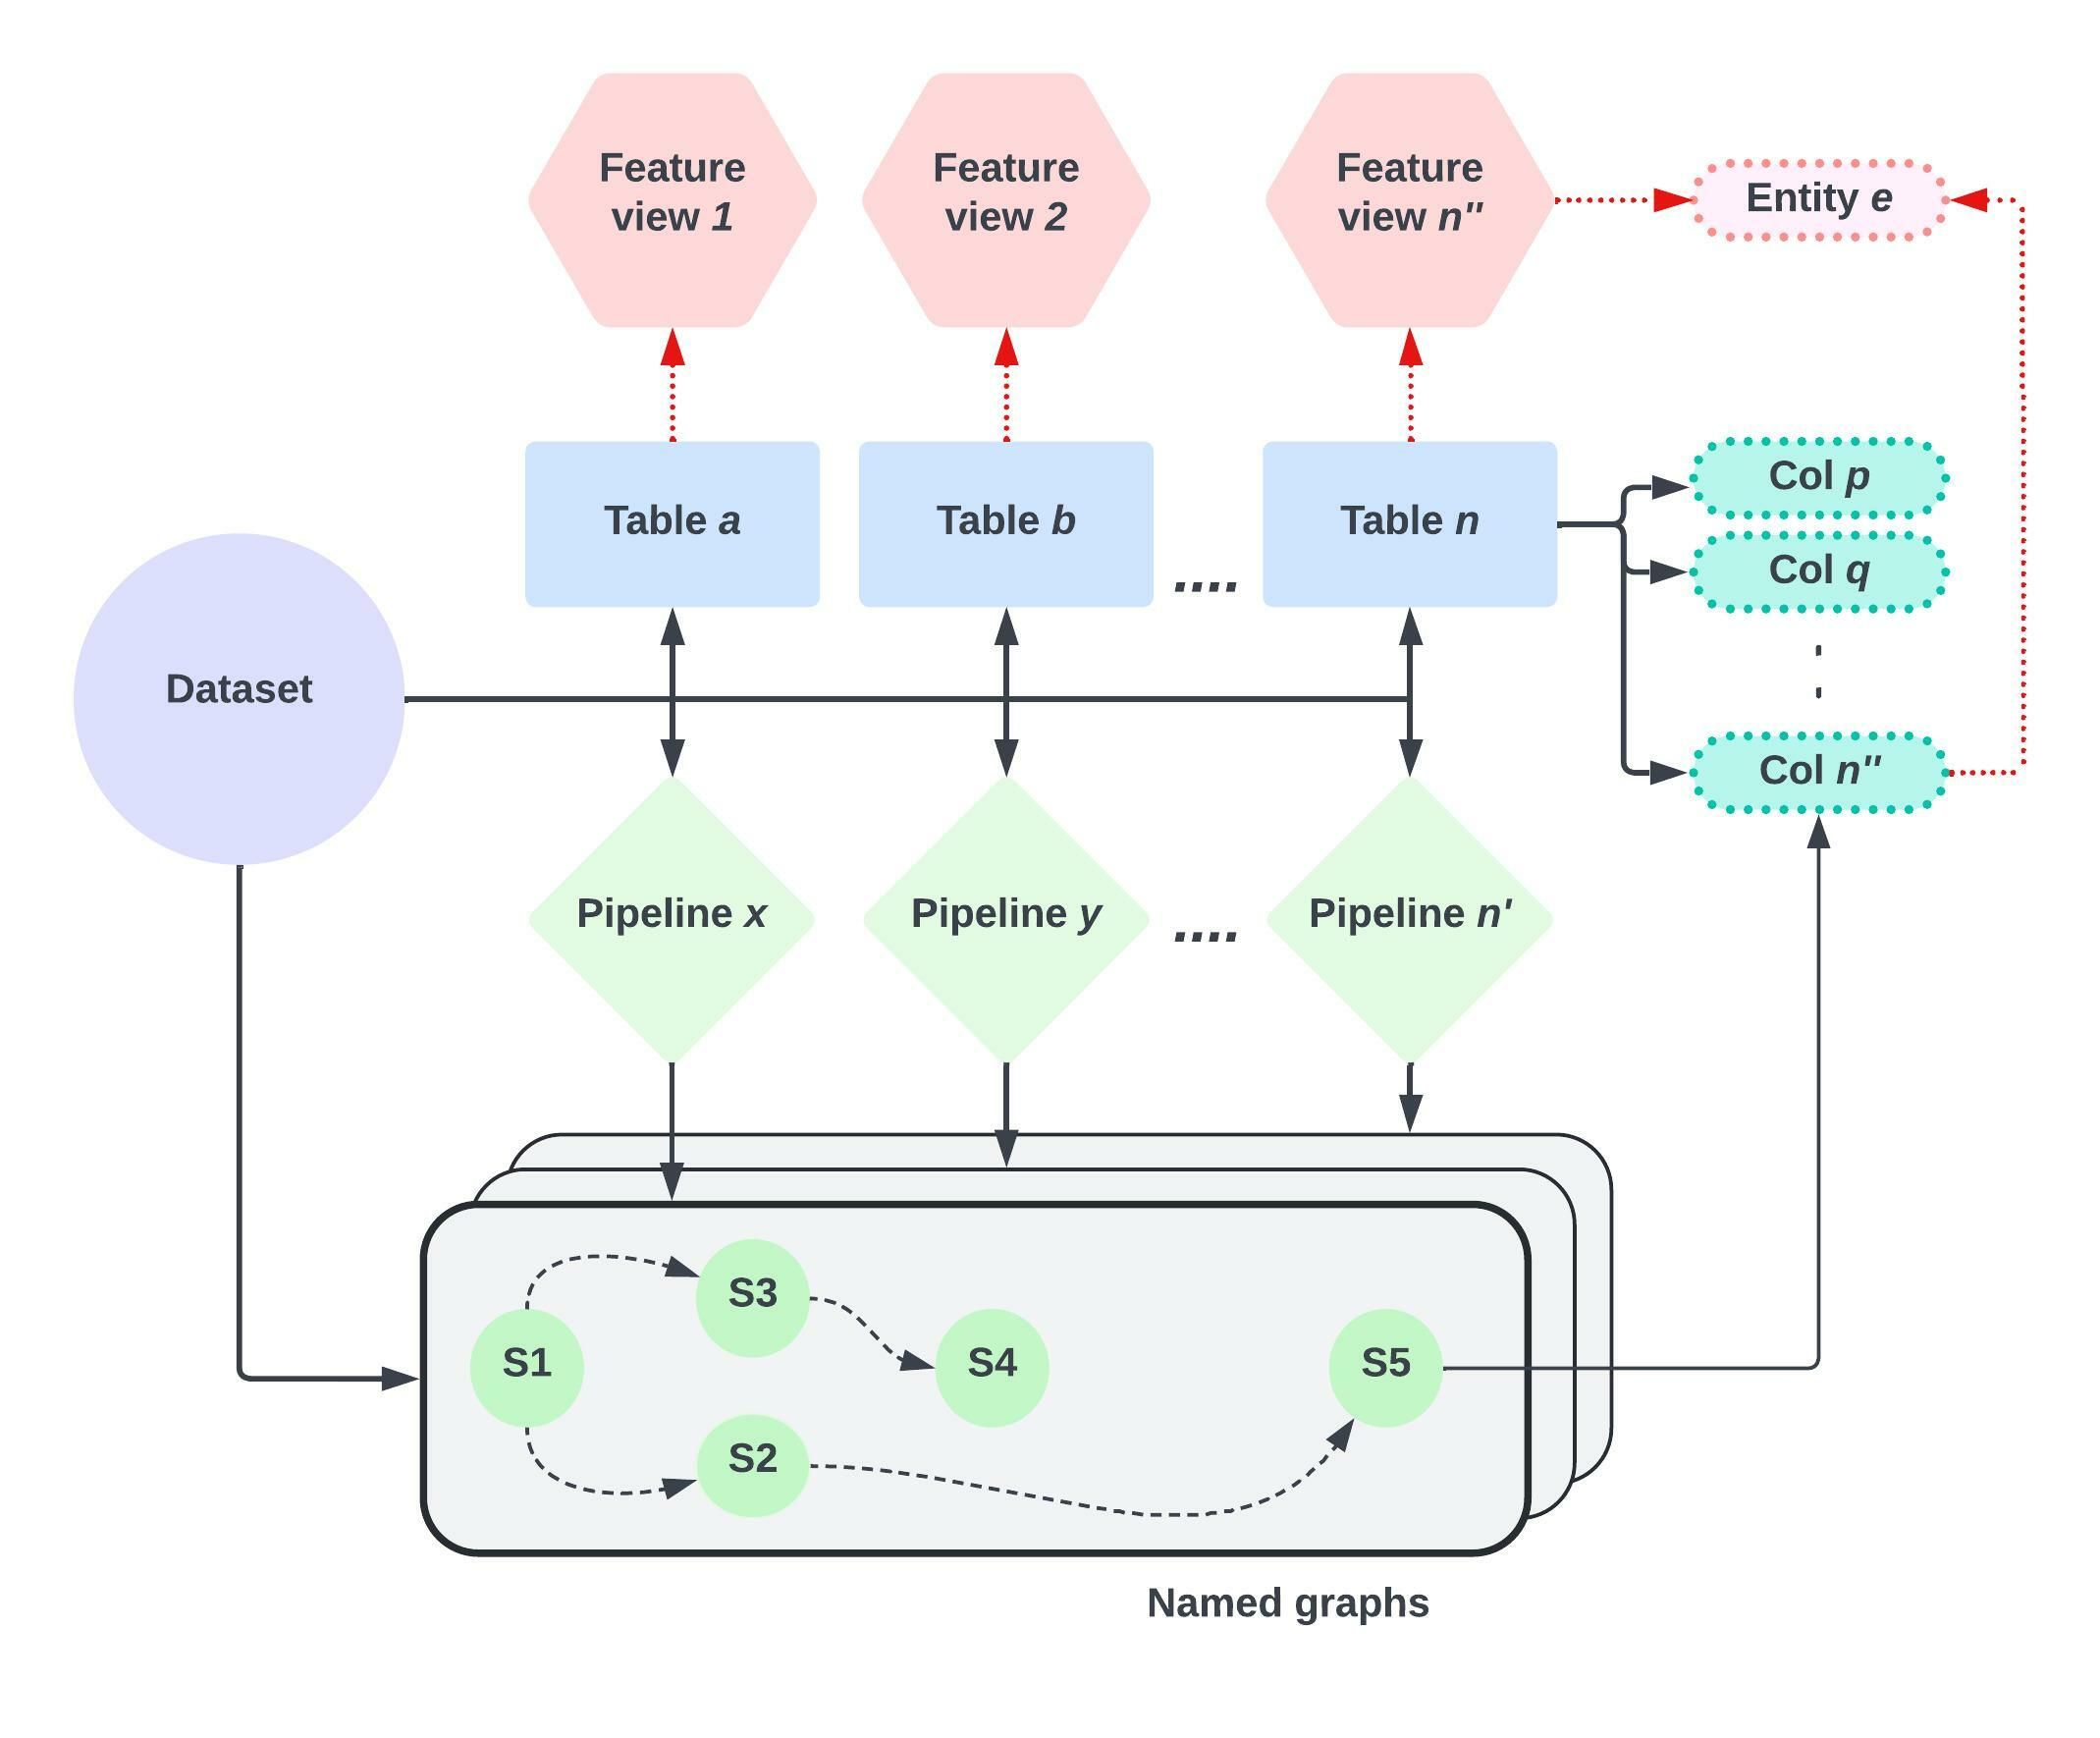


KGFarm exploits the abstracted link between the KGLiDS graph and Farm graph
   * <code> kgfarm.recommend_feature_transformations</code> returns all possible set of feature transformations that exists in the database.
   * <b> You can pass your existing <code>entity_df</code> to <code>kgfarm.recommend_feature_transformations(entity:pd.Dataframe)</code> to look for possible feature transformations for that very entity dataframe.

In [15]:
transformation_info = kgfarm.recommend_feature_transformations(entity_df)
transformation_info

Narrowing recommendations w.r.t entity_df


100%|██████████| 8/8 [00:00<00:00, 1467.89it/s]


,Transformation,Package,Function,Library,Feature,Feature_view,Pipeline
0,LabelEncoder,preprocessing,LabelEncoder.fit_transform( ),sklearn,"[month, job, contact, education, marital, poutcome, loan]",Feature_view_11,SL_BankMarketing_TermDeposit_Classification


**Transforming features on the fly**

<code>kgfarm.apply_transformations</code> applies the recommended set of transformations from <code>kgfarm.recommend_feature_transformations</code> to your <code>entity_df</code>

   * <code>kgfarm.apply_transformations</code> expects the following as the input:<br>
     1. Transformation metadata from <code>kgfarm.recommend_feature_transformations</code> and
     2. <code>entity_df</code>


In [16]:
entity_df = kgfarm.apply_transformation(transformation_info.iloc[0], entity_df)
entity_df

Applying LabelEncoder transformation


100%|██████████| 7/7 [00:00<00:00, 262.96it/s]

7 feature(s) ['month', 'job', 'contact', 'education', 'marital', 'poutcome', 'loan'] transformed successfully!


,event_timestamp,customer_id,age,balance,day,duration,campaign,pdays,previous,n_accounts,deposit,education,job,marital,contact,loan,month,poutcome,housing,membership
0,2022-08-19 21:14:10.333878,C_07001,56,45,5,1467,1,-1,0,2,0,1,0,1,2,0,8,3,0,1
1,2022-08-16 03:22:34.333878,C_07006,56,830,6,1201,1,-1,0,2,1,2,4,1,2,1,8,3,1,1
2,2022-08-18 20:02:49.333878,C_07007,60,545,6,1030,1,-1,0,2,1,1,5,0,2,0,8,3,1,1
3,2022-08-15 17:35:53.333878,C_07012,29,199,7,1689,4,-1,0,2,1,2,4,1,2,1,8,3,1,1
4,2022-08-19 10:44:03.333878,C_07014,31,703,8,943,2,-1,0,2,1,2,9,2,2,0,8,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6117,2022-08-18 22:57:36.333878,C_18158,39,733,16,83,4,-1,0,2,1,1,7,1,2,0,6,3,0,0
6118,2022-08-16 11:26:06.333878,C_18159,32,29,19,156,2,-1,0,2,1,1,9,2,0,0,1,3,0,0
6119,2022-08-19 10:12:16.333878,C_18159,41,-386,20,477,1,-1,0,2,1,1,9,2,0,0,1,3,0,1
6120,2022-08-17 07:20:05.333878,C_18160,34,3043,20,670,1,-1,0,1,1,1,9,1,0,1,8,0,0,1


**Feature selection**<br>
KGFarm performs feature selection based on ANOVA test <code>kgfarm.select_features()</code>, takes the following parameters as input:
  1. entity dataframe
  2.  depndent variable / target / label i.e. <i>y</i>
  3.  <code>f_value_threshold</code> (2.0 default)

100%|██████████| 20/20 [00:00<00:00, 70.97it/s]


Analyzing features


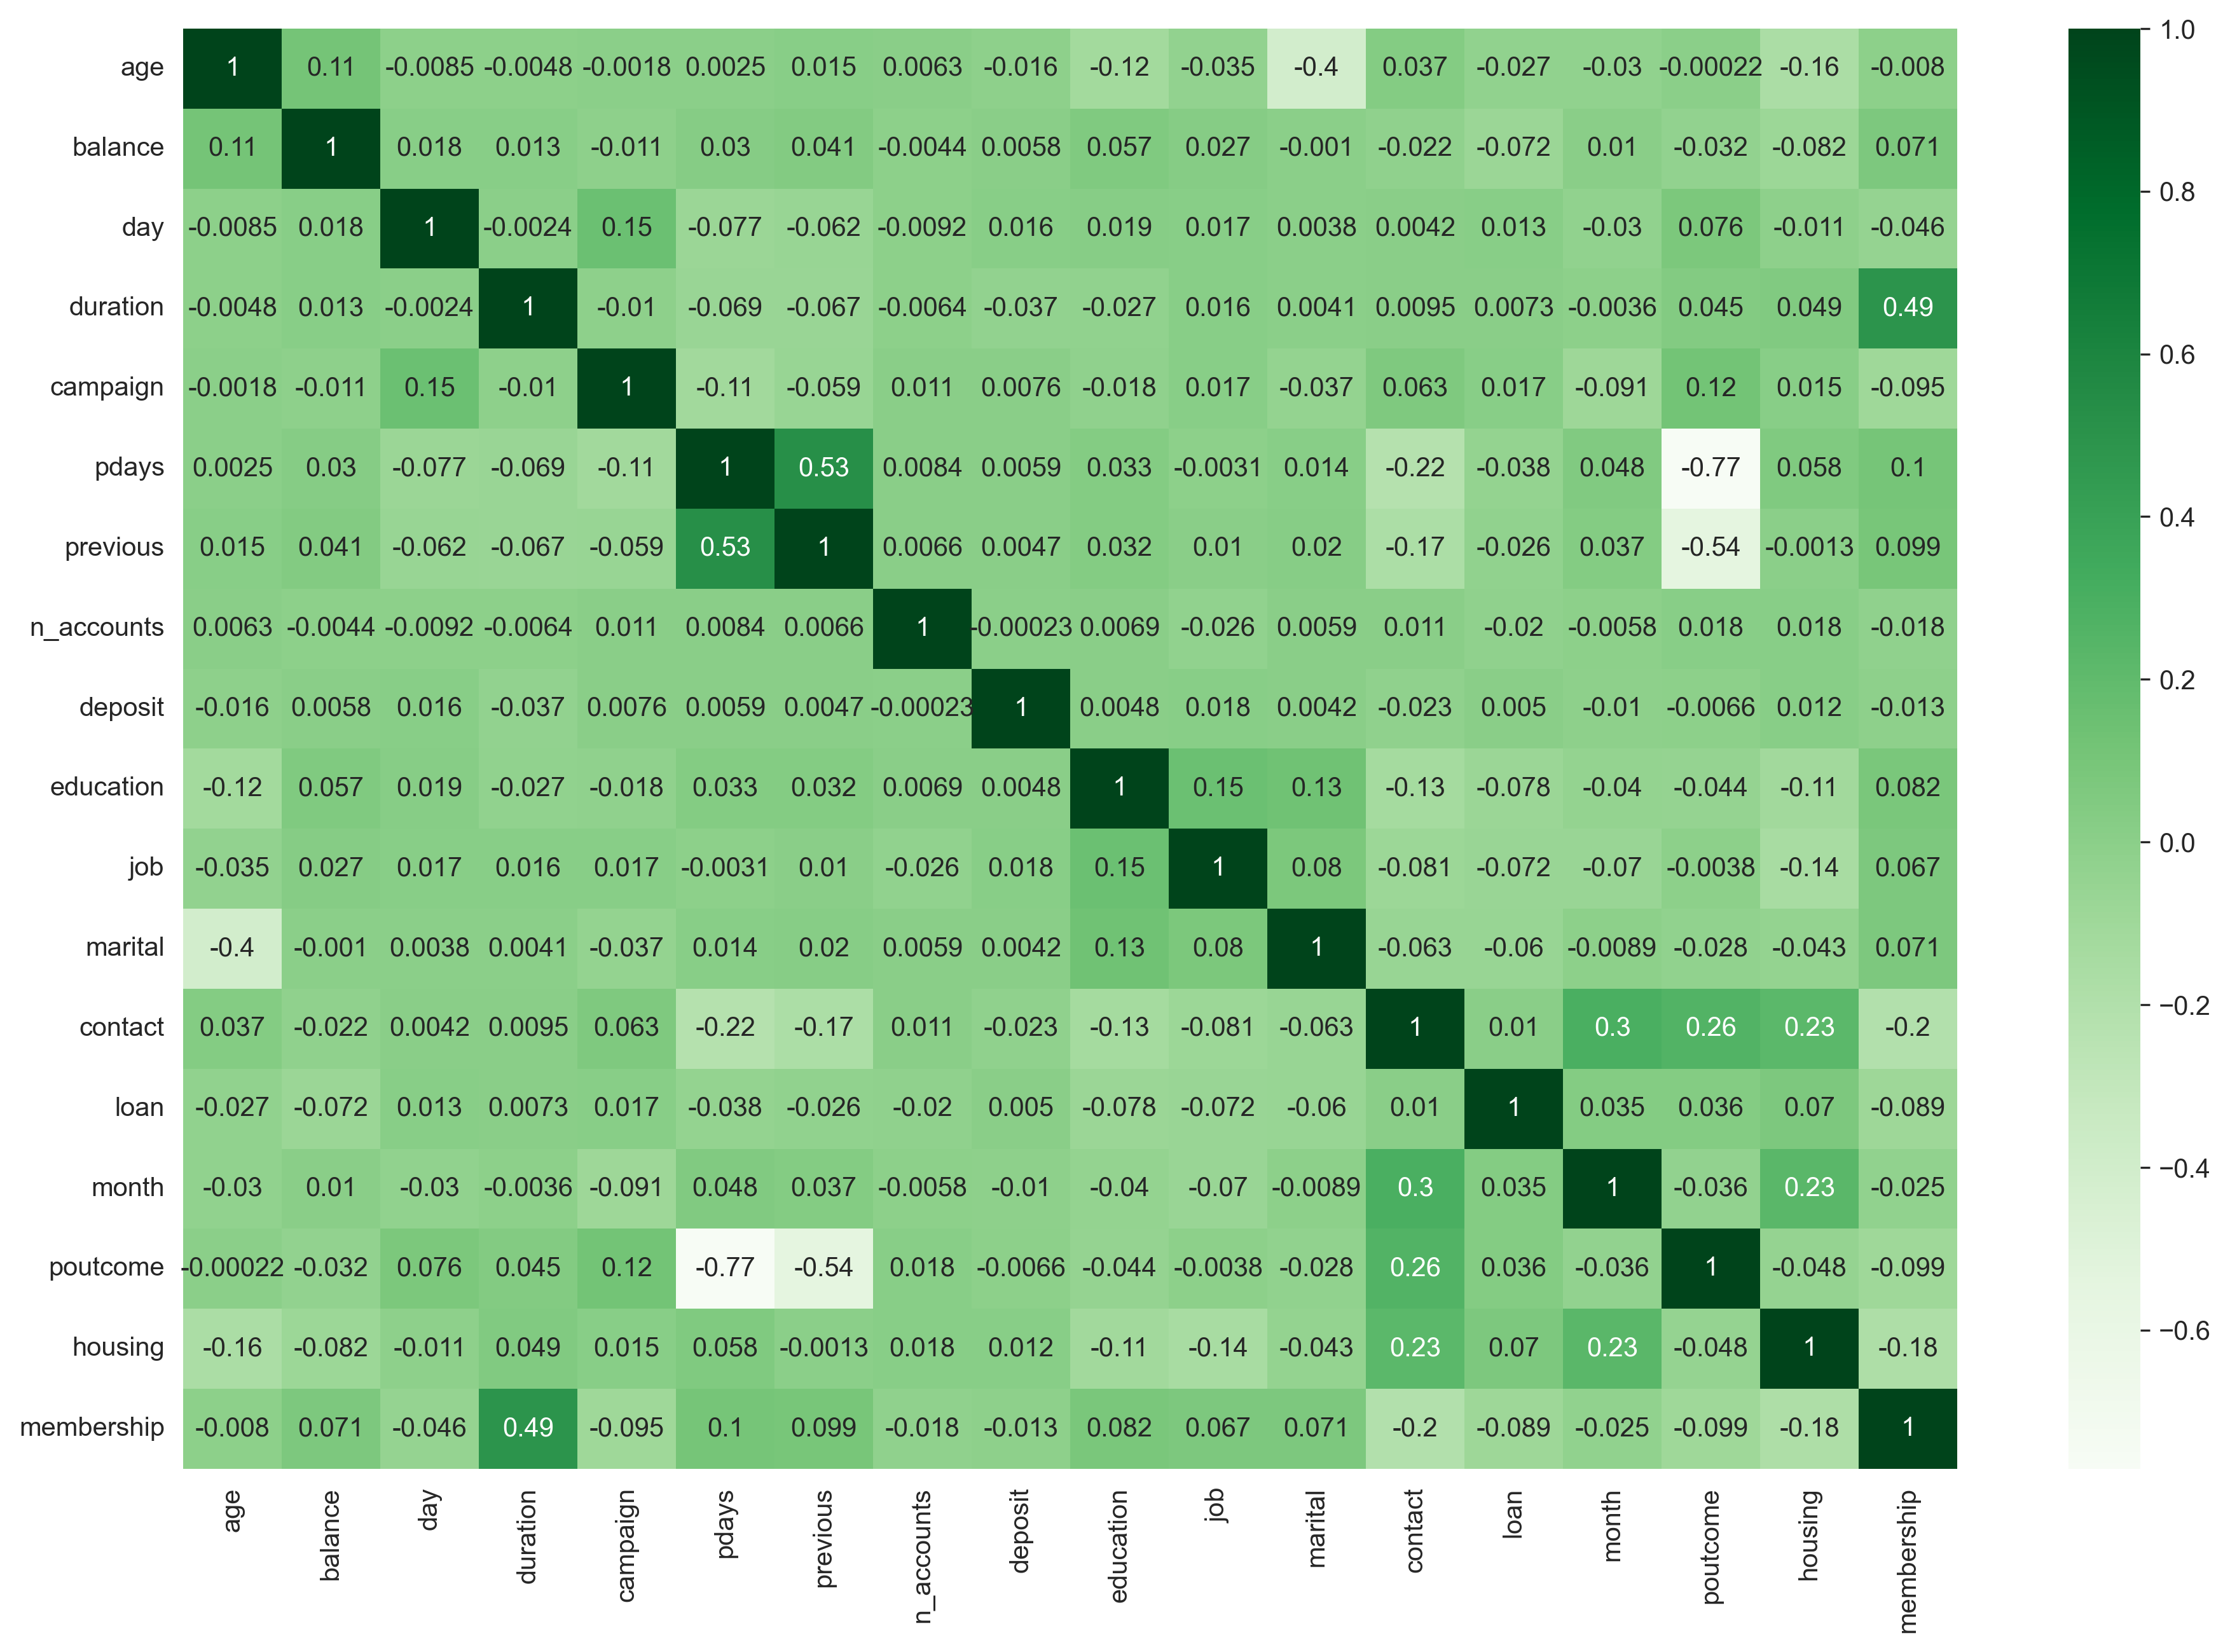

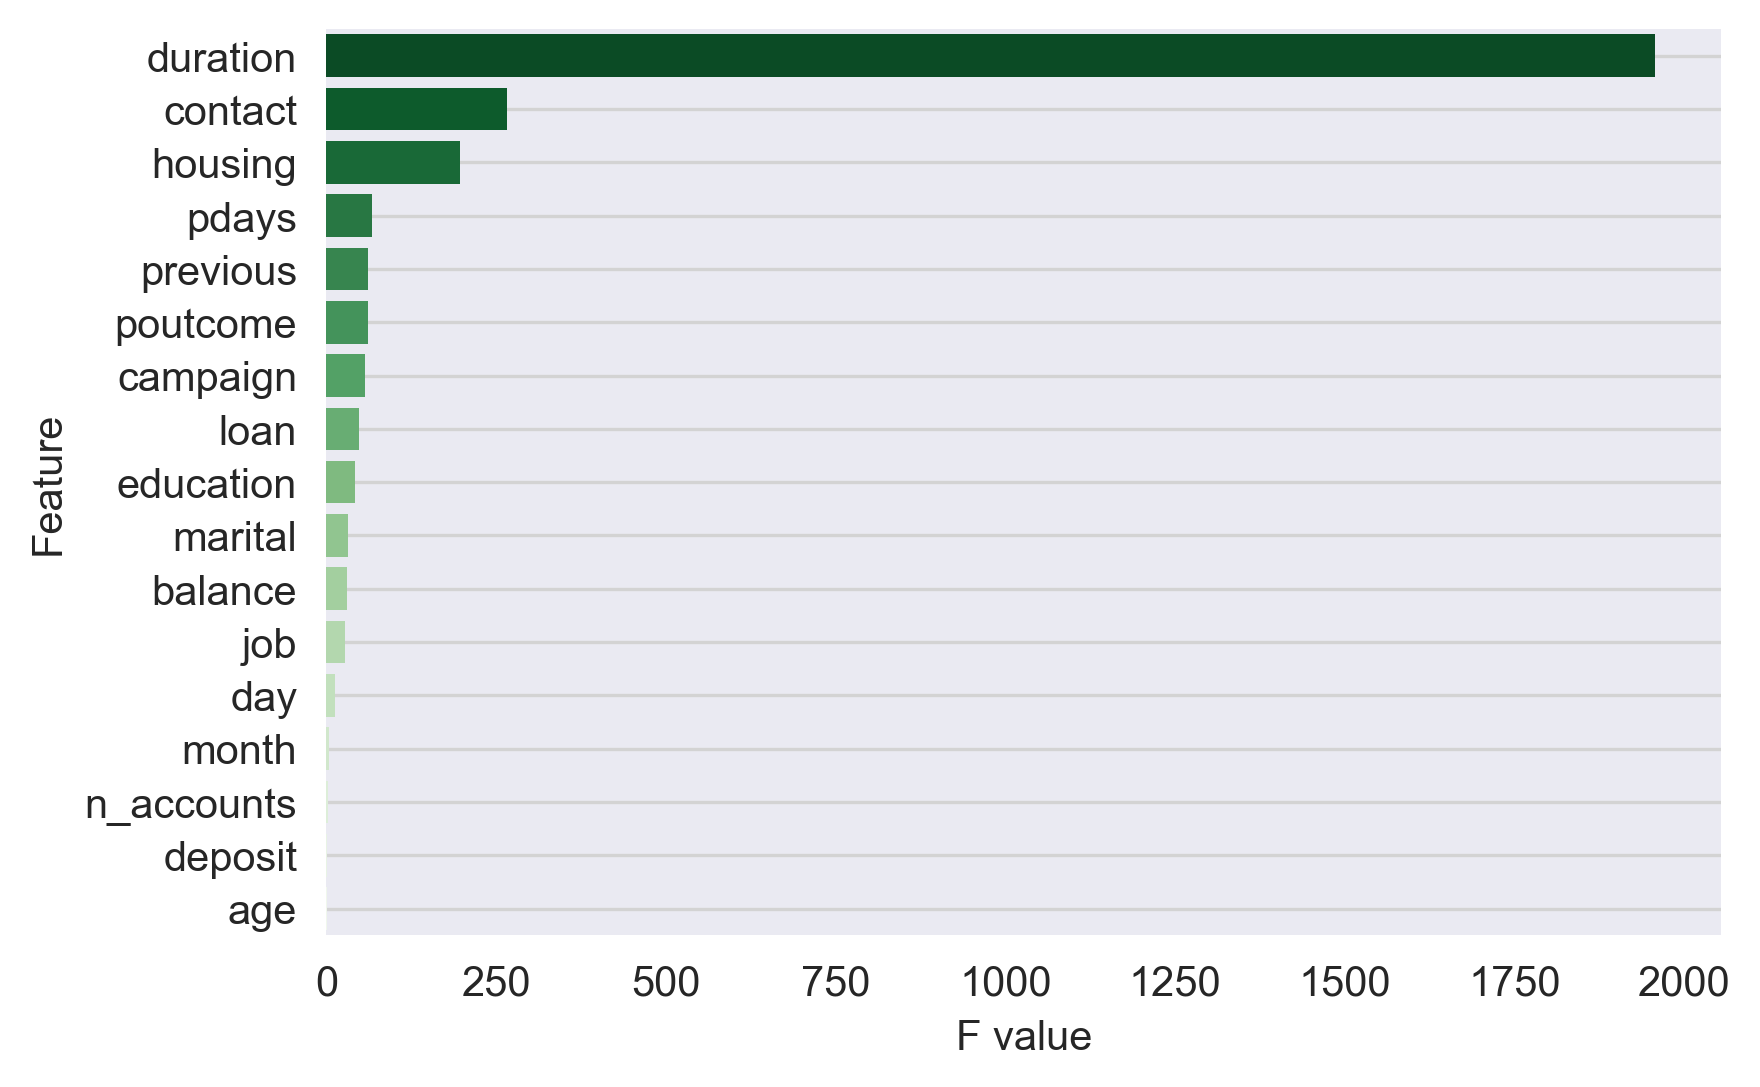

Searching features for enriched dataframe
15 feature(s) ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'education', 'job', 'marital', 'contact', 'loan', 'month', 'poutcome', 'housing'] were selected based on previously abstracted pipelines


,age,balance,day,duration,campaign,pdays,previous,education,job,marital,contact,loan,month,poutcome,housing
0,56,45,5,1467,1,-1,0,1,0,1,2,0,8,3,0
1,56,830,6,1201,1,-1,0,2,4,1,2,1,8,3,1
2,60,545,6,1030,1,-1,0,1,5,0,2,0,8,3,1
3,29,199,7,1689,4,-1,0,2,4,1,2,1,8,3,1
4,31,703,8,943,2,-1,0,2,9,2,2,0,8,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6117,39,733,16,83,4,-1,0,1,7,1,2,0,6,3,0
6118,32,29,19,156,2,-1,0,1,9,2,0,0,1,3,0
6119,41,-386,20,477,1,-1,0,1,9,2,0,0,1,3,0
6120,34,3043,20,670,1,-1,0,1,9,1,0,1,8,0,0


In [18]:
X, y = kgfarm.select_features(entity_df, dependent_variable='membership', select_by='pipeline',
                                        plot_correlation=True, plot_anova_test=True, show_f_value=False)
X

**Re-training the classifiers with fresh and enrich set of selected features**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

random_forest_classifier.fit(X_train, y_train)
gradient_boosting_classifier.fit(X_train, y_train)
naive_bayes_classifier.fit(X_train, y_train)

y_pred = random_forest_classifier.predict(X_test)
f1_random_forest_classifier = round(f1_score(y_test, y_pred), 3)
y_pred = gradient_boosting_classifier.predict(X_test)
f1_gradient_boosting_classifier = round(f1_score(y_test, y_pred), 3)
y_pred = naive_bayes_classifier.predict(X_test)
f1_naive_bayes_classifier = round(f1_score(y_test, y_pred), 3)

kgfarm_approach = {'Random forest classifier': f1_random_forest_classifier,
                         'Gradient boosting classifier': f1_gradient_boosting_classifier,
                         'Naive bayes classifier': f1_naive_bayes_classifier}

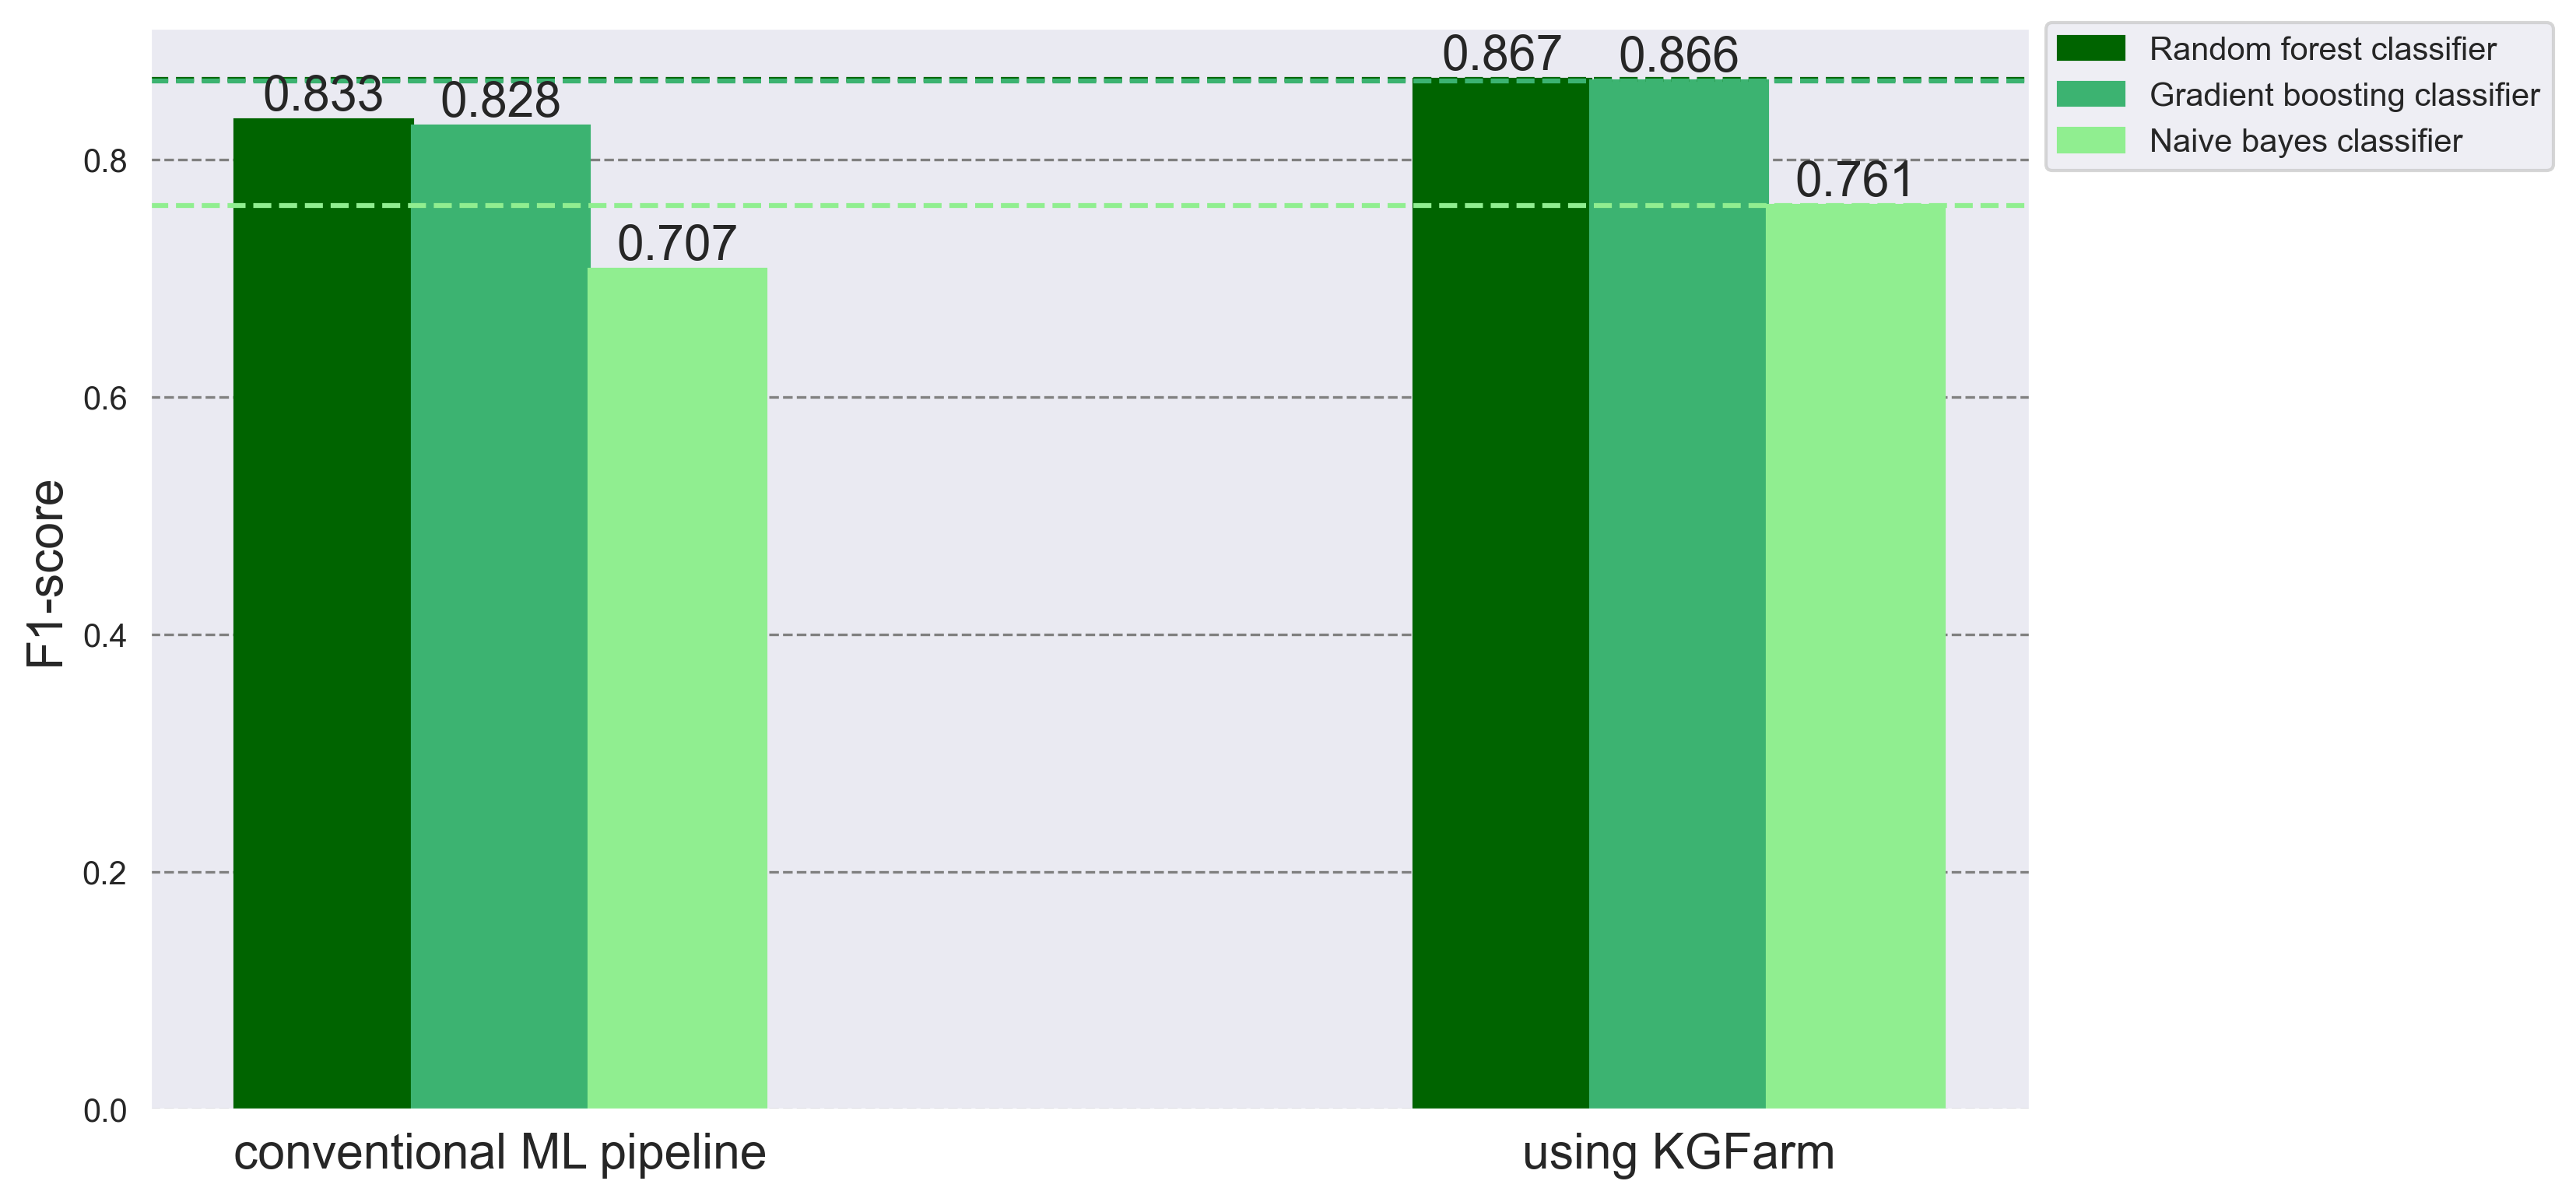

In [20]:
plot_comparison(conventional_approach, kgfarm_approach)